#Notebook by Ivan Goncharov
https://www.youtube.com/channel/UCyn1QFyonOr-NKVtX3gw0vw?view_as=subscriber

Huge credit to:

*   Jeff Heaton: https://www.youtube.com/watch?v=T-MCludVNn4
*   Mitchell Jolly: https://github.com/mitchelljy/DCGAN-Keras



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Creating images folder

!mkdir images

In [ ]:
#This command deletes images folder

!rm -r images

https://www.kaggle.com/gasgallo/faces-data-new

In [ ]:
#Run this if you have the face dataset in your Google Drive and you wanna copy it
#Link to the original dataset on Kaggle: https://www.kaggle.com/gasgallo/faces-data-new
#It's just about 40MB and I've put it on my GDrive for your convenience here:
#https://drive.google.com/file/d/1AUiWyBMGUAlDpctfHBoIgw0ZgREuByWG/view?usp=sharing


%%capture
!unzip drive/'My Drive'/gans/images.zip 

In [ ]:
#Flipping the image data for augmentation
 
import cv2
import os
 
folder = 'images'
images = os.listdir(folder)
print(len(images))
for name in images:
 
  image = cv2.imread(os.path.join(folder, name))
  image = cv2.flip(image, 1)
 
  cv2.imwrite(os.path.join(folder, "mirrowed_"+name), image)
  
 
print(len(os.listdir('images')))

7864
15728


In [ ]:
#Run this if you have IMDB-WIKI dataset on your Google Drive and wanna copy it

!tar -xf drive/'My Drive'/facerec/imdb_crop.tar

In [ ]:
#Run this if you wanna download and unpack IMDB-WIKI Dataset here and untar it
#This might take a while tho
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

!tar -xf imdb_crop.tar

In [ ]:
#IMDB-WIKI code
import os
 
ages = os.scandir('imdb_crop')
length = 0
for age in ages:
   
   if '.mat' not in str(age.path): 
   
     
     length+=len(os.listdir(age.path))
   
print(length)
import scipy.io
 
imdbMat = scipy.io.loadmat('imdb_crop/imdb.mat')
imdbPlace = imdbMat['imdb'][0][0]
print(imdbPlace)
print(len(imdbPlace))
for item in imdbPlace:
  print(item)
  print(len(item[0]))
from shutil import copy2
import cv2
import os
 
 
place = imdbPlace
where='imdb_crop'
total = 0

#How many images you wanna use. Note: too many might not fit into RAM
maxImages = 30000
startFrom = 300000
 
 
listyList = []
 #The actual number of images there is 460723
for i in range(startFrom, 460723):
  if i % 10000 ==0:
    print(i)
  
  bYear = int(place[0][0][i]/365) #birth year
  taken = place[1][0][i] #photo taken
  path = place[2][0][i][0]
  gender = place[3][0][i] # Female/Male
  name = place[4][0][i] # Name
  faceBox= place[5][0][i] # Face coords
  faceScore = place[6][0][i] #Face score
  secFaceScore = place[7][0][i] #Sec face score
  
  #Calculating shit
  age = taken - bYear
  
  
  faceScore = str(faceScore)
  secFaceScore = str(secFaceScore)
  
  
  
  
  if 'n' not in faceScore: # n as in Inf; if true, implies that there isn't a face in the image
    
    if 'a' in secFaceScore: #a as in NaN; implies that no second face was found
      
      if age >= 0: 
      
        try:
          gender = int(gender) #gender 1 male, gender 0 female
          
          
          moveFrom = os.path.join(where,path)
          moveTo = os.path.join('images', "imdb_" + str(total) + ".jpg")
          #os.rename(moveFrom, moveTo)
          copy2(moveFrom, moveTo)
          total += 1 
          #max number of images
          if total >= maxImages:
            break
          
          
               
        except:
          #print('Failed with gender')
          continue
 
  
  
  
        
        
print(total)
#!ls images

The following packages will be used to implement a basic GAN system in Python/Keras.

In [ ]:
import os
print(len(os.listdir('images')))

15728


In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline
 
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
 
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

images/moors.17.jpg


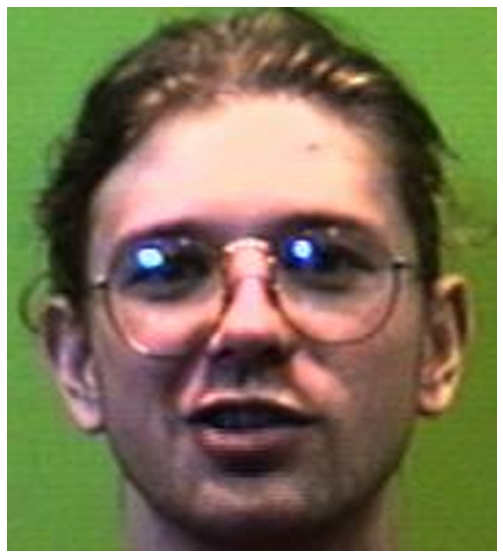

In [ ]:
import random
import os
 
#Showing a random image from the dataset
a = os.path.join("images", random.choice(os.listdir('images')))
print(a)
imShow(a)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os 
import time
import matplotlib.pyplot as plt



# Generation resolution - Must be square 
# Training data is also scaled to this.



GENERATE_SQUARE = 128
IMAGE_CHANNELS = 3
 
# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
 
# Size vector to generate images from
SEED_SIZE = 100
 
# Configuration
DATA_PATH = '.'
EPOCHS = 350
BATCH_SIZE = 32
BUFFER_SIZE = 60000
 
print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


In [ ]:
#Here we'll use cv2 to load the images, preprocess them to have their values be between 0 and 255

import cv2


gray = 0

 
 
training_data = []
faces_path = os.path.join(DATA_PATH,'images')
for filename in tqdm(os.listdir(faces_path)):
    path = os.path.join(faces_path,filename)
    
    image = cv2.resize(cv2.imread(path), (GENERATE_SQUARE, GENERATE_SQUARE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE),Image.ANTIALIAS)

    #Code that fixes IMDB-WIKI gray scale images by skipping on them
    if len(image.shape) != 3:
      gray += 1

      if gray % 100 == 0:
        #print("GRAY", gray)
        pass
      continue

    training_data.append(image)

print("GRAY EXCLUDED", gray)
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE, GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)

training_data = training_data / 255

 


GRAY EXCLUDED 0


We will use a TensorFlow **Dataset** object to actually hold the images.  This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.  

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>


In [ ]:
def build_generator(SEED_SIZE, channels):
        noise_shape = (SEED_SIZE,)
             
        model = Sequential()
        model.add(Dense(4 * 4 * 64, activation="relu", input_shape=noise_shape))
        model.add(Reshape((4, 4, 64))) # 4 x 4 x 64
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 8 x 8 x 1024
        model.add(Conv2D(1024, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 16 x 16 x 512
        model.add(Conv2D(512, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 32 x 32 x 256
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 64 x 64 x 128
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())  # 128 x 128 x 64
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(32, kernel_size=3, padding="same")) # 128 x 128 x 32
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(3, kernel_size=3, padding="same")) # 128 x 128 x 3
        model.add(Activation("sigmoid"))

        model.summary()

        return model



def build_discriminator(image_shape):        

        img_shape = (128, 128, 3)

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))  # 64 x 64 x 32
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))  # 32 x 32 x 64 
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))  # 16 x 16 x 128
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))  # 8 x 8 x 256
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))  # 4 x 4 x 512
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(64)) #I used 64 neurons for the small face dataset and 256 for IMDB-WIKI
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))


        model.add(Dense(1, activation='sigmoid'))

        model.summary()


        return model

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              103424    
_________________________________________________________________
reshape_14 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 4, 4, 64)          256       
_________________________________________________________________
up_sampling2d_70 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 8, 8, 1024)        590848    
_________________________________________________________________
activation_98 (Activation)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 8, 8, 1024)      

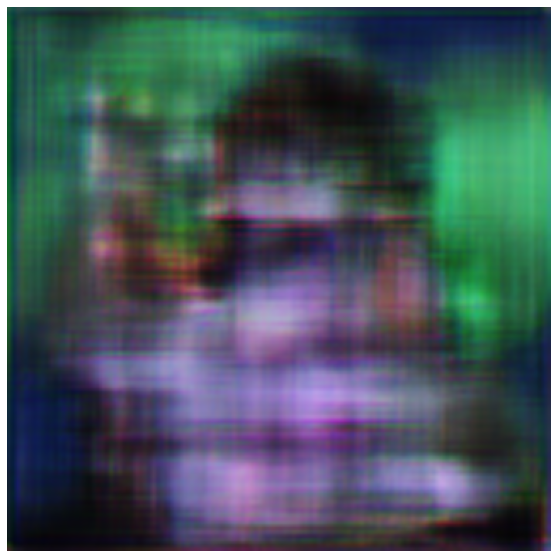

In [ ]:
#Run this cell of code to test the generator on a random-noise input

def imShowCV(image):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline
  import numpy as np


  height, width = image.shape[:2]

  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)


imShowCV(generated_image[0].numpy())



In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
 
discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_109 (Bat (None, 32, 32, 64)      

Loss functions must be developed that allow the generator and discriminator to be trained in an adversarial way.  Because these two neural networks are being trained independently they must be trained in two separate passes.  This requires two separate loss functions and also two separate updates to the gradients.  When the discriminator's gradients are applied to decrease the discriminator's loss it is important that only the discriminator's weights are update.  It is not fair, nor will it produce good results, to adversarially damage the weights of the generator to help the discriminator.  A simple backpropagation would do this.  It would simultaneously affect the weights of both generator and discriminator to lower whatever loss it was assigned to lower.

Figure 7.TDIS shows how the discriminator is trained.

**Figure 7.TDIS: Training the Discriminator**
![Training the Discriminator](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_2.png "Training the Discriminator")

Here a training set is generated with an equal number of real and fake images.  The real images are randomly sampled (chosen) from the training data.  An equal number of random images are generated from random seeds.  For the discriminator training set, the $x$ contains the input images and the $y$ contains a value of 1 for real images and 0 for generated ones.

Likewise, the Figure 7.TGEN shows how the generator is trained.

**Figure 7.TGEN: Training the Generator**
![Training the Generator](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_3.png "Training the Generator")

For the generator training set, the $x$ contains the random seeds to generate images and the $y$ always contains the value of 1, because the optimal is for the generator to have generated such good images that the discriminiator was fooled into assigning them a probability near 1.

In [ ]:


# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.  This does not need to be the case.  If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.  

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:


def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)
 
  #generated_images = 0.5 * generated_images + 0.5
 
  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1
 
          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  if not os.path.exists('output_model'):
    os.makedirs('output_model')
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  generator.save(os.path.join('output_model', f"train-{cnt}.h5"))

The following function is where most of the training takes place for both the discriminator and the generator.  This function was based on the GAN provided by the [TensorFlow Keras exmples](https://www.tensorflow.org/tutorials/generative/dcgan) documentation.  The first thing you should notice about this function is that it is annotated with the **tf.function** annotation.  This causes the function to be precompiled and improves performance.

This function trans differently than the code we previously saw for training.  This code makes use of **GradientTape** to allow the discriminator and generator to be trained together, yet separately.  



In [ ]:


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
 
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)
 
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
 
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss, real_output, fake_output

In [ ]:


def train(dataset, epochs):
  #NOTE: FIXED SEED
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()
  num_of_images = len(os.listdir('images'))

  for epoch in range(epochs):
    epoch_start = time.time()
 
    gen_loss_list = []
    disc_loss_list = []
    real_list = []
    fake_list = []

    
    for image_batch in tqdm(dataset, position=1, leave=True, total = int(num_of_images/BATCH_SIZE)):

      # print("%s/%s"%(step_done, num_of_images), end = ' ')
      # print "\r{0}".format((float(i)/n)*100),


      
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

      real_out = t[2].numpy()
      fake_out = t[3].numpy()
      # print('real', real_out)
      # print('fake', fake_out)


      real_out[real_out > .5] = 1
      real_out[real_out <= .5] = 0

      height, width = real_out.shape[:2]
      real_right = sum(real_out) / (height * width)

      real_list.append(real_right)

      fake_out[fake_out > .5] = 0
      fake_out[fake_out <= .5] = 1

      height, width = fake_out.shape[:2]
      fake_right = sum(fake_out) / (height * width)

      fake_list.append(fake_right)






 
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    r_acc = sum(real_list) / len(real_list)
    f_acc = sum(fake_list) / len(fake_list)


    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},rl={float(r_acc)}%, fk={float(f_acc)}%')
    save_images(epoch+1,fixed_seed)
 
  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)


Epoch 1, gen loss=0.6626142859458923,disc loss=1.2764490842819214,rl=0.3896087408065796%, fk=1.0%


KeyboardInterrupt: ignored

In [ ]:
#Run this to delete output and output_model folders 

!rm -r output
!rm -r output_model

In [ ]:
!zip -r output.zip output #zipping output folder

  adding: output/ (stored 0%)
  adding: output/train-31.png (deflated 0%)
  adding: output/train-9.png (deflated 0%)
  adding: output/train-17.png (deflated 0%)
  adding: output/train-8.png (deflated 0%)
  adding: output/train-44.png (deflated 0%)
  adding: output/train-45.png (deflated 0%)
  adding: output/train-29.png (deflated 0%)
  adding: output/train-2.png (deflated 0%)
  adding: output/train-20.png (deflated 0%)
  adding: output/train-11.png (deflated 0%)
  adding: output/train-3.png (deflated 0%)
  adding: output/train-28.png (deflated 0%)
  adding: output/train-7.png (deflated 0%)
  adding: output/train-18.png (deflated 0%)
  adding: output/train-63.png (deflated 0%)
  adding: output/train-47.png (deflated 0%)
  adding: output/train-46.png (deflated 0%)
  adding: output/train-58.png (deflated 0%)
  adding: output/train-6.png (deflated 0%)
  adding: output/train-38.png (deflated 0%)
  adding: output/train-49.png (deflated 0%)
  adding: output/train-27.png (deflated 0%)
  adding

In [ ]:
!zip -r output_model.zip output_model #zipping folder with trained generators, might weigh a lot

In [ ]:
#Copying a generator to Gdrive
!cp output_model/train-8.h5 drive/"My Drive"/gans